# Cars

In [2]:
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import tsensor

dtype = torch.float

In [61]:
def show(m, b, X=df_cars.WGT, Y=df_cars.MPG):
    fig, ax = plt.subplots(figsize=(4,3))

    ax.scatter(X, Y, s=15, color='#F46C43', alpha=.5)
    ax.plot(X, m * X + b, lw=.5, color='black')
    ax.set_title(f"$y = {m:.3f}x + {b:.2f}$")
    # ax.set_xlim(500,1000)
    # ax.set_ylim(0,2100)
    if sum(X)/len(X)<1.0:
        ax.set_xlabel("Weight (Standardized)")
    else:
        ax.set_xlabel("Weight")
    ax.set_ylabel("MPG")

    plt.show()

In [62]:
df_cars = pd.read_csv("../data/cars.csv")
df_cars.head(2)

,MPG,CYL,ENG,WGT
0,18.0,8,307.0,3504
1,15.0,8,350.0,3693


## Brute force linear model

In [63]:
# brute force model parameter space search (m,b)
best = (1e100,0,0)
for m in np.linspace(-0.005,-.01,num=5):
    for b in np.linspace(42,47,num=5):
        y = m * df_cars.WGT + b
        mse = np.mean((y - df_cars.MPG)**2)
        if mse < best[0]:
            best = (mse,m,b)
        print(f"{m:4.3f},{b:4.3f} => MSE {mse:.1f}")
m = best[1]
b = best[2]
print(f"BEST {m:.3f}*x + {b:.3f}")

-0.005,42.000 => MSE 37.2
-0.005,43.250 => MSE 47.9
-0.005,44.500 => MSE 61.7
-0.005,45.750 => MSE 78.7
-0.005,47.000 => MSE 98.8
-0.006,42.000 => MSE 20.1
-0.006,43.250 => MSE 21.5
-0.006,44.500 => MSE 26.1
-0.006,45.750 => MSE 33.7
-0.006,47.000 => MSE 44.5
-0.007,42.000 => MSE 33.0
-0.007,43.250 => MSE 25.1
-0.007,44.500 => MSE 20.3
-0.007,45.750 => MSE 18.7
-0.007,47.000 => MSE 20.2
-0.009,42.000 => MSE 75.8
-0.009,43.250 => MSE 58.6
-0.009,44.500 => MSE 44.5
-0.009,45.750 => MSE 33.6
-0.009,47.000 => MSE 25.8
-0.010,42.000 => MSE 148.6
-0.010,43.250 => MSE 122.1
-0.010,44.500 => MSE 98.7
-0.010,45.750 => MSE 78.5
-0.010,47.000 => MSE 61.4
BEST -0.007*x + 45.750


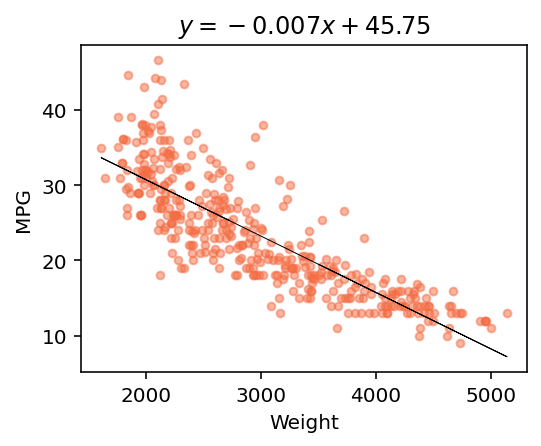

In [64]:
show(m, b)

## Linear model with numpy, one learning rate

### Manual gradient computation of loss function

use the sum, ignoring 1/n constant.

$$
loss = \sum_i^n E^2 \text{ where } E = \hat{y} - y = mx + b - y
$$

$$
\begin{array}{rcl}
\frac{\partial}{\partial m} loss & = & \sum_i^n E^2\\
 & = & 2 \sum_i^n E \frac{\partial E}{\partial m}\\
 & = & \sum_i^n E x\\
\end{array}
$$

$$
\begin{array}{rcl}
\frac{\partial}{\partial b} loss & = & \sum_i^n E^2\\
 & = & 2 \sum_i^n E \frac{\partial E}{\partial b}\\
 & = & \sum_i^n E\\
\end{array}
$$

Loss function is a saddle like this:

<img src="images/2d-loss.png" width="400">

0.3888762318943596
Epoch     0 0.39,45.00: MSE loss  1504308.584 MAE  1179.47
Epoch    10 0.26,45.00: MSE loss   699317.259 MAE   804.15
Epoch    20 0.18,45.00: MSE loss   325101.330 MAE   548.25
Epoch    30 0.12,45.00: MSE loss   151139.752 MAE   373.77
Epoch    40 0.08,45.00: MSE loss    70270.318 MAE   254.82
Epoch    50 0.05,45.00: MSE loss    32676.582 MAE   173.71
Epoch    60 0.03,45.00: MSE loss    15200.401 MAE   118.41
Epoch    70 0.02,45.00: MSE loss     7076.257 MAE    80.70
Epoch    80 0.01,45.00: MSE loss     3299.590 MAE    54.99
Epoch    90 0.01,45.00: MSE loss     1543.933 MAE    37.47
Epoch   100 0.00,45.00: MSE loss      727.781 MAE    25.52
Epoch   110 -0.00,45.00: MSE loss      348.377 MAE    17.44
Epoch   120 -0.00,45.00: MSE loss      172.004 MAE    12.06
Epoch   130 -0.00,45.00: MSE loss       90.013 MAE     8.59
Epoch   140 -0.01,45.00: MSE loss       51.898 MAE     6.44
Epoch   150 -0.01,45.00: MSE loss       34.180 MAE     5.13
Epoch   160 -0.01,45.00: MSE los

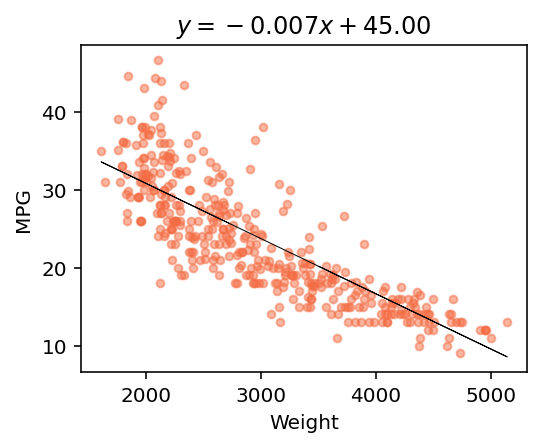

In [65]:
n = len(df_cars)
X = np.array(df_cars.WGT).reshape(n,1)
Y = np.array(df_cars.MPG).reshape(n,1)

# Randomly initialize weights
m = np.random.random(size=1)[0]
print(m)
b = 45.0 # get it very close to an answer
tolerance = 18.7
learning_rate = .00000000001 # almost too fast for m, but incredibly slow for b.  Loss surface is a valley
nepochs=200
for epoch in range(nepochs+1):
    # Forward pass over all x,y pairs: compute predicted y
    y_pred = m * X + b
    E = y_pred - Y
    loss = np.mean(E**2)
    if loss < tolerance:
        break
    if epoch % 10 == 0:
        mae = np.mean(np.abs(y_pred - Y))
        print(f"Epoch {epoch:5d} {m:4.2f},{b:4.2f}: MSE loss {loss:12.3f} MAE {mae:8.2f}")

    # Computes the gradient of loss with respect to all Variables with requires_grad=True.
    m_grad = np.sum(E * X)
    b_grad = np.sum(E)
    
    m = m - learning_rate * m_grad
    b = b - learning_rate * b_grad
    
print(f"LAST        {m:4.2f},{b:4.2f}: MSE loss {loss:12.3f} MAE {mae:8.2f}")
show(m, b)

## Linear model with standardized/normalized variables

Standardizing variables to be mean centered and with standard deviation one, improves convergence speed. Previously we had to choose a `b` that was very close to the answer.

0.274567195130622 0.47418926362684477
Epoch     0 0.27,0.47: MSE loss      592.101 MAE    22.97
Epoch    10 -5.72,20.85: MSE loss       25.981 MAE     3.70
Epoch    20 -6.40,23.15: MSE loss       18.770 MAE     3.26
Epoch    30 -6.48,23.41: MSE loss       18.678 MAE     3.28
Epoch    40 -6.49,23.44: MSE loss       18.677 MAE     3.28
Epoch    50 -6.49,23.45: MSE loss       18.677 MAE     3.28
LAST        -6.49,23.45: MSE loss       18.677 MAE     3.28


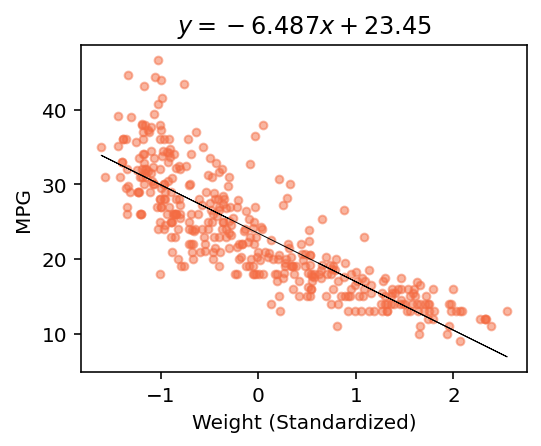

In [66]:
n = len(df_cars)
X = np.array(df_cars.WGT).reshape(n,1)
Y = np.array(df_cars.MPG).reshape(n,1)

X = StandardScaler().fit_transform(X)

# Randomly initialize weights
m = np.random.random(size=1)[0]
b = np.random.random(size=1)[0]
print(m,b)
learning_rate = .0005 # almost too fast for m, but incredibly slow for b.  Loss surface is a valley
nepochs=50
for epoch in range(nepochs+1):
    # Forward pass over all x,y pairs: compute predicted y
    y_pred = m * X + b
    E = y_pred - Y
    loss = np.mean(E**2)
    if epoch % 10 == 0:
        mae = np.mean(np.abs(y_pred - Y))
        print(f"Epoch {epoch:5d} {m:4.2f},{b:4.2f}: MSE loss {loss:12.3f} MAE {mae:8.2f}")

    # Computes the gradient of loss with respect to all Variables with requires_grad=True.
    m_grad = np.sum(E * X)
    b_grad = np.sum(E)
    
    m = m - learning_rate * m_grad
    b = b - learning_rate * b_grad
    
print(f"LAST        {m:4.2f},{b:4.2f}: MSE loss {loss:12.3f} MAE {mae:8.2f}")
show(m, b, X=X, Y=df_cars.MPG)

## Linear model with pytorch, one learning rate

Epoch     0 -0.39,-0.50: MSE loss      629.075 MAE    23.94
Epoch    10 -5.83,20.88: MSE loss       25.714 MAE     3.69
Epoch    20 -6.42,23.17: MSE loss       18.758 MAE     3.26
Epoch    30 -6.48,23.42: MSE loss       18.678 MAE     3.28
LAST        -6.48,23.42: MSE loss       18.678 MAE     3.28


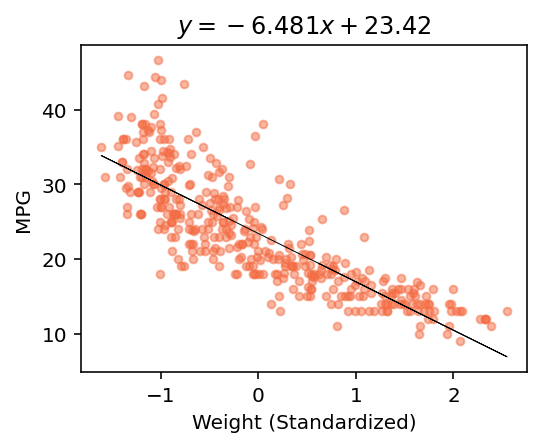

In [79]:
n = len(df_cars)
X = torch.tensor(df_cars.WGT).reshape(n,1)
Y = torch.tensor(df_cars.MPG).reshape(n,1)
X = torch.tensor(StandardScaler().fit_transform(X))

# Randomly initialize weights
m = torch.randn(1, 1, requires_grad=True)  # <-- track for autograd
b = torch.randn(1, 1, requires_grad=True) # too far away from correct answer for one learning rate
learning_rate = .1 # almost too fast for m, but incredibly slow for b.  Loss surface is a valley
nepochs=30
for epoch in range(nepochs+1):
    # Forward pass over all x,y pairs: compute predicted y
    y_pred = m * X + b
    loss = torch.mean((y_pred - Y)**2)
    if epoch % 10 == 0:
        with torch.no_grad():
            mae = torch.mean(torch.abs(y_pred - Y))
            print(f"Epoch {epoch:5d} {m.detach().item():4.2f},{b.detach().item():4.2f}: MSE loss {loss:12.3f} MAE {mae:8.2f}")

    # Computes the gradient of loss with respect to all Variables with requires_grad=True.
    # After this call a.grad and b.grad will be Variables holding the gradient
    # of the loss with respect to a and b respectively
    loss.backward()
    
    # Update a and b using gradient descent; a.data and b.data are Tensors,
    # a.grad and b.grad are Variables and a.grad.data and b.grad.data are Tensors
    with torch.no_grad():
        m -= learning_rate * m.grad
        b -= learning_rate * b.grad
    
#     print(m.detach().item(), b.detach().item())
    # Zero the gradients
    m.grad.zero_()
    b.grad.zero_()

m = m.detach().item()
b = b.detach().item()
print(f"LAST        {m:4.2f},{b:4.2f}: MSE loss {loss:12.3f} MAE {mae:8.2f}")
show(m, b, X=X, Y=df_cars.MPG)

## Linear model with pytorch using Adam optimizer

Epoch     0 -0.78,0.72: MSE loss      567.832 MAE    22.73
Epoch    10 -7.83,19.51: MSE loss       35.972 MAE     4.76
Epoch    20 -5.84,28.91: MSE loss       48.931 MAE     6.22
Epoch    30 -6.72,25.90: MSE loss       24.758 MAE     4.08
Epoch    40 -6.54,21.71: MSE loss       21.708 MAE     3.47
Epoch    50 -6.29,22.54: MSE loss       19.544 MAE     3.29
Epoch    60 -6.68,24.17: MSE loss       19.231 MAE     3.40
Epoch    70 -6.40,23.63: MSE loss       18.719 MAE     3.29
LAST       -6.44,23.54: MSE loss       18.719 MAE     3.29


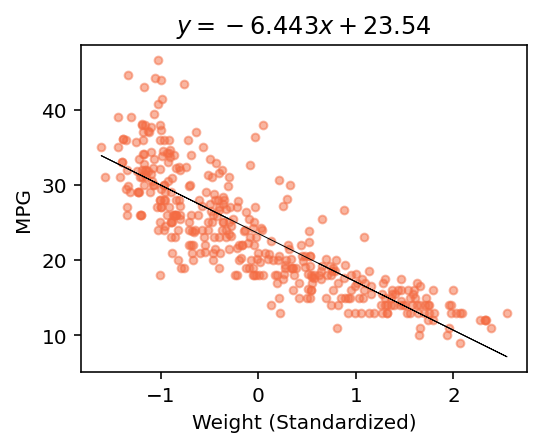

In [107]:
n = len(df_cars)
X = torch.tensor(df_cars.WGT).reshape(n,1)
Y = torch.tensor(df_cars.MPG).reshape(n,1)
X = torch.tensor(StandardScaler().fit_transform(X))

# Randomly initialize weights
m = torch.randn(1, 1, requires_grad=True)  # <-- track for autograd
b = torch.randn(1, 1, requires_grad=True)

learning_rate = 2
optimizer = torch.optim.Adam([m,b], lr=learning_rate)
nepochs=70
for epoch in range(nepochs+1):
    # Forward pass over all x,y pairs: compute predicted y
    with tsensor.clarify():
        y_pred = m * X + b
        loss = torch.mean((y_pred - Y)**2)
    if epoch % 10 == 0:
        with torch.no_grad():
            mae = torch.mean(torch.abs(y_pred - Y))
            print(f"Epoch {epoch:5d} {m.detach().item():4.2f},{b.detach().item():4.2f}: MSE loss {loss:12.3f} MAE {mae:8.2f}")

    # Backprop to compute gradients of w1, w2, ... with respect to loss
    optimizer.zero_grad()
    loss.backward() # autograd computes w1.grad, b1.grad, ...
    optimizer.step()
m = m.detach().item()
b = b.detach().item()
print(f"LAST       {m:4.2f},{b:4.2f}: MSE loss {loss:12.3f} MAE {mae:8.2f}")

show(m, b, X=X, Y=df_cars.MPG)